In [33]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import rasterio
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil


# NOTE: change to your own path when setting workspace
ws = r'C:\Users\emers\.rainfall'


### Step 1: Get Microsoft Building Footprint Data

The data needs to be broken into a subset, even smaller than the United States--no need for 129 million buildings in a massive geojson. Instead, we have to parse the quadkeys (an indexing technique used in vector tiling) into lat/long. For this, we will use the `mercantile` package.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Mercantile Documentation](https://mercantile.readthedocs.io/_/downloads/en/latest/pdf/)

In [2]:
# set target state
state = 'arizona'

# get state bounds
state_df = gpd.read_file(f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/{state}.geojson')
state_gdf = gpd.GeoDataFrame(state_df, crs=4326)

In [3]:
# get building data
filename = f'{state.title()}.geojson.zip'
filepath = os.path.join(ws, filename)
url = f'https://usbuildingdata.blob.core.windows.net/usbuildings-v2/{filename}'

with requests.get(url, allow_redirects=True, stream=True) as r:
    with open(filepath, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
        print('zip downloaded')

        with ZipFile(filepath, 'r') as z:
            z.extractall(
                path=ws
                )

print(f'file unzipped successfully ({os.path.getsize(filename.strip(".zip")) / 1000} MB)')

buildings_gdf = gpd.read_file(filepath.strip('.zip'))

zip downloaded
file unzipped successfully (845767.832 MB)


In [4]:
# load precip data
xds = xr.open_dataset(os.path.join(ws, 'precip.nc'))

# drop the "expver" dimension
no_expver = xds.reduce(np.nansum, dim='expver')

# get mean, max, min precipitation over the 10 year period
mean = no_expver.reduce(np.mean, dim='time', keep_attrs=True)
max = no_expver.reduce(np.max, dim='time', keep_attrs=True)
min = no_expver.reduce(np.min, dim='time', keep_attrs=True)

# verify time dimension has been removed from each
for i in [max, mean, min]:
    assert 120 not in i.to_array().shape 

mean_df = mean.to_dataframe()
max_df = max.to_dataframe()
min_df = min.to_dataframe()

print(mean_df.tail(5))
print(max_df.tail(5))
print(min_df.tail(5))


                          tp
longitude latitude          
-108.0    32.00     0.000645
          31.75     0.000628
          31.50     0.000587
          31.25     0.000650
          31.00     0.000684
                          tp
longitude latitude          
-108.0    32.00     0.003283
          31.75     0.003353
          31.50     0.003656
          31.25     0.004519
          31.00     0.004999
                     tp
longitude latitude     
-108.0    32.00     0.0
          31.75     0.0
          31.50     0.0
          31.25     0.0
          31.00     0.0


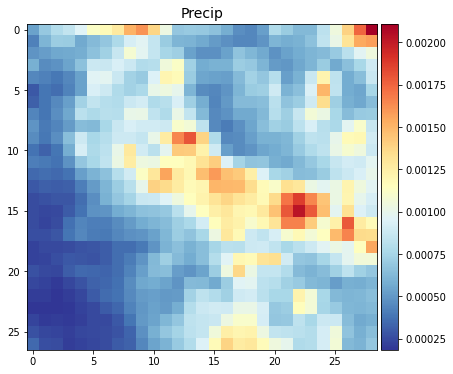

In [31]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(mean.to_array()[0], cmap='RdYlBu_r')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [25]:
# Converts the NC file with precipitation data to A Raster
precip = no_expver['tp']
precip = precip.rio.set_spatial_dims(x_dim='latitude', y_dim='longitude')
reordered = precip.transpose('time', 'latitude', 'longitude')
reordered.rio.write_crs('epsg:32612', inplace=True)
reordered.rio.to_raster(r'precip_raster.tiff')

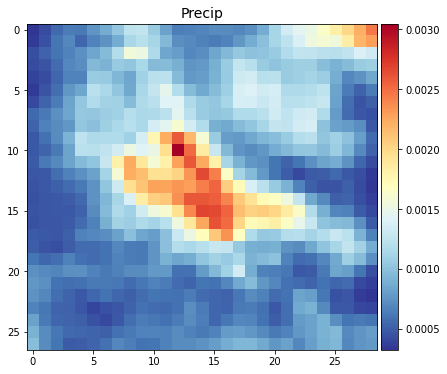

In [40]:
# Opens raster created in last cell, change file path to your own
precip_raster = rasterio.open(r'C:\Users\emers\.rainfall\precip_raster.tiff')

#
precip_array = precip_raster.read(1)

fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(precip_array, cmap='RdYlBu_r')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [45]:
precip_array

array([[0.00033187, 0.00042921, 0.00055123, 0.00063324, 0.00062557,
        0.00075342, 0.0008736 , 0.00102811, 0.00124547, 0.00126264,
        0.00106629, 0.00081642, 0.00065041, 0.00065424, 0.00067908,
        0.00071141, 0.00070958, 0.00069041, 0.00073808, 0.0008736 ,
        0.00113113, 0.00135415, 0.00144766, 0.0015125 , 0.00165168,
        0.00181954, 0.00200272, 0.00221441, 0.00244711],
       [0.00034904, 0.00044255, 0.0006084 , 0.00069241, 0.00054356,
        0.00066574, 0.00074192, 0.00086776, 0.00113296, 0.00121114,
        0.00112346, 0.00094994, 0.00072291, 0.00069808, 0.00065991,
        0.00064274, 0.00067524, 0.00076492, 0.00086776, 0.00099178,
        0.00112346, 0.00124547, 0.00139616, 0.00152784, 0.00159068,
        0.00155834, 0.00184437, 0.00217824, 0.00228876],
       [0.00043305, 0.00052456, 0.0006104 , 0.00066941, 0.00073808,
        0.00083543, 0.00095361, 0.00119013, 0.00156401, 0.00152017,
        0.00115963, 0.00084309, 0.00080109, 0.00068858, 0.00071908,
  